# Tabula Rasa

---

---

### Overview

This notebook trains a mixed monotonic model, with sub-models to generate arbitrary quantile predictions and estimate epistemic uncertainty, using `TabulaRasaRegressor()`.

It's designed to work with Pandas DataFrame's and takes advantage of class types and feature names to cut down on code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabularasa.TabulaRasa import TabulaRasaRegressor

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

Let's convert `x3` to a `category` data type so that we can generate embeddings for it (`TabulaRasaRegressor()` automatically handles this for all columns with `object` or `category` data types).

In [3]:
df['x3'] = df['x3'].astype('category')

---

### Initialize  and train

When initializing the model, we typically pass 1 argument:
- `monotonic_constraints`: A `dict` where keys are features (column names on `df`) to take on monotonic relationships with the `targets` and values are 1 or -1 to signify the direction of that relationship: increasing or decreasing (respectively).

`TabulaRasaRegressor()` also accepts named arguments, which are passed to the methods that define the three models behind the scenes.  Review the source code for `TabulaRasaRegressor()._define_model()` for more detail.  Here, we only specify `lr=0.003`.

In [4]:
model = TabulaRasaRegressor(monotonic_constraints={'x1': 1, 'x2': 1},
                            lr=0.003)

Now, when we run `.fit()`, we'll train 3 models:
- The first generates standard predictions.
- The second can be used to estimate epistemic uncertainty.
- The third can generate predictions for arbitrary quantiles.

Note, numeric columns are automatically standardized, and categorical feature mappings are created based on the feature dataset passed to `fit`.  Therefore, subsequent `fit` calls for incremental updates are expected to have a similar distribution, and any new categories will receive generic embedding values.

Also note, the `X` input argument is required to be a `pandas.DataFrame` rather than `numpy.array` so that monotonic features can be properly handled.

In [5]:
model.fit(df[['x1', 'x2', 'x3', 'x4']], df[['y']])

*** Training expectation model ***
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8816        0.7330  1.5021
      2        0.6557        0.5365  1.4646
      3        0.4120        0.3317  1.4828
      4        0.2583        0.2943  1.4713
      5        0.2149        0.3178  1.5003
      6        0.1979        0.2636  1.4601
      7        0.1914        0.2688  1.4934
      8        0.1842        0.2577  1.4665
      9        0.1809        0.3243  1.4961
     10        0.1980        0.2318  1.4810
     11        0.2095        0.2328  1.4759
     12        0.1801        0.2518  1.4591
     13        0.1715        0.2552  1.4857
     14        0.1738        0.2437  1.4660
     15        0.1704        0.2293  1.4903
     16        0.1723        0.2296  1.4726
     17        0.1651        0.2304  1.4755
     18        0.1645        0.2188  1.4711
     19        0.1616        0.2263  1.4535
     20        0.1619        0.2589  1.46

     81        0.0103        0.0101  0.0564
     82        0.0102        0.0101  0.0451
     83        0.0102        0.0101  0.0437
     84        0.0102        0.0100  0.0422
     85        0.0102        0.0100  0.0419
     86        0.0102        0.0100  0.0457
     87        0.0102        0.0100  0.0430
     88        0.0101        0.0100  0.0406
     89        0.0101        0.0100  0.0430
     90        0.0101        0.0099  0.0394
     91        0.0101        0.0099  0.0505
     92        0.0101        0.0099  0.0409
     93        0.0101        0.0099  0.0437
     94        0.0101        0.0099  0.0413
     95        0.0100        0.0099  0.0446
     96        0.0100        0.0099  0.0438
     97        0.0100        0.0099  0.0437
     98        0.0100        0.0098  0.0445
     99        0.0100        0.0099  0.0410
    100        0.0100        0.0098  0.0411
    101        0.0100        0.0098  0.0418
    102        0.0100        0.0098  0.0460
    103        0.0099        0.0

    228        0.0091        0.0089  0.0550
    229        0.0091        0.0090  0.0435
    230        0.0091        0.0089  0.0386
    231        0.0091        0.0089  0.0479
    232        0.0091        0.0089  0.0419
    233        0.0091        0.0089  0.0429
    234        0.0090        0.0089  0.0392
    235        0.0090        0.0089  0.0448
    236        0.0090        0.0089  0.0412
    237        0.0091        0.0089  0.0492
    238        0.0091        0.0090  0.0459
    239        0.0091        0.0089  0.0390
    240        0.0091        0.0090  0.0396
    241        0.0091        0.0089  0.0394
    242        0.0090        0.0089  0.0438
    243        0.0090        0.0089  0.0463
    244        0.0090        0.0089  0.0454
    245        0.0090        0.0089  0.0401
    246        0.0090        0.0090  0.0401
    247        0.0091        0.0090  0.0509
    248        0.0091        0.0090  0.0436
    249        0.0091        0.0089  0.0441
    250        0.0090        0.0

We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Note, the `.predict()` method for `TabulaRasaRegressor()` accepts a data frame as well.  This data frame must include all training features, but does not need to include target column(s).

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict(dfc)
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

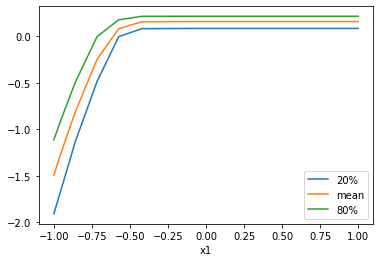

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Epistemic uncertainty

`TabulaRasaRegressor()` automatically trains and Orthornormal certificates model, and includes a method `.estimate_uncertainty()`, which accepts a data frame that must include all training features, but does not need to contain target column(s).

In [9]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.estimate_uncertainty(dfc)
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

And we can see from the plot below that uncertainties rise above 1 when projecting outside of the bounds we trained.  There is a bump in the middle, but it does not exceed 1 or align perfectly with the gap in our training data from 0 to 0.5.  Instead we see higher uncertainty when the function shows  high degree of curvature.

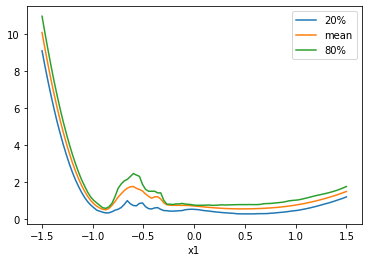

In [10]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Aleatoric uncertainty

`TabulaRasaRegressor()` also automatically trains a simultaneous quantile regression model.  Let's see how to use that.

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [11]:
df_slice = df[df['x3'] == 0].copy()

The `.predict_quantile()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [12]:
p05 = model.predict_quantile(df_slice, q=0.05)
p = model.predict(df_slice)
p50 = model.predict_quantile(df_slice, q=0.5)
p95 = model.predict_quantile(df_slice, q=0.95)

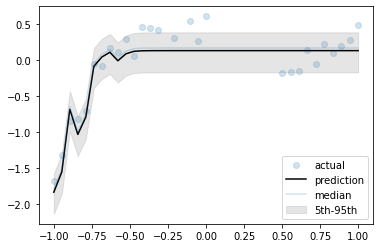

In [13]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p.flatten(), color='black', label='prediction')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

We can see the 5th and 95th percentile prediction bounds capture the variation of most points around the median and base prediction model estimate, and can be used to approximate the aleatoric uncertainty in our model.